<a href="https://colab.research.google.com/github/rmrichardson88/ToolWearDeepLearningRegressor/blob/main/Tool_Wear_Deep_Learning_Regressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras import Model
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.backend import int_shape
from keras import backend as K
from keras.layers import GlobalAveragePooling2D, Dense, Reshape, multiply, Add, Activation
from tensorflow.keras.layers import Flatten, Input, Conv2D, GlobalMaxPooling1D, BatchNormalization, LSTM, \
Conv1D, MaxPooling2D, Dropout, Reshape, concatenate, GlobalAveragePooling2D, Dense, MaxPooling1D
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
sns.set_theme(style = 'darkgrid')

from google.colab import drive
# Mount drive
drive.mount('/content/drive/')
path = ('/content/drive/MyDrive/ToolWearData')
# Define cutters and their respective wear labels
cutters_to_read = ['c1', 'c4', 'c6']

In [ ]:
def get_labels(cutter):
    #Creates a dataframe with the wear measurements for a given cutter
    label_path = f'{path}/{cutter}/{cutter}_wear.csv'
    df_get_labels_out = pd.read_csv(label_path)
    df_get_labels_out['cut_index'] = cutter[0]+'_'+cutter[1] +'_'+ df_get_labels_out.cut.astype('str').str.zfill(3)
    df_get_labels_out['cutter'] = cutter
    flute_cols = [col for col in df_get_labels_out.columns if 'flute' in col]
    df_get_labels_out['average_wear'] = df_get_labels_out[flute_cols].mean(axis=1)
    df_get_labels_out['max_wear'] = df_get_labels_out[flute_cols].max(axis=1)
    df_get_labels_out['min_wear'] = df_get_labels_out[flute_cols].min(axis=1)
    return df_get_labels_out

def get_all_cutter_labels(cutters):
    #Creates a dataframe with wear measurements for multiple cutters
    df_get_all_cutter_labels_out = pd.DataFrame()
    for get_all_cutter_labels_cutter in cutters:
        df_get_all_cutter_labels_out = pd.concat([df_get_all_cutter_labels_out, get_labels(get_all_cutter_labels_cutter)])
    return df_get_all_cutter_labels_out

def create_input_array(cut_index_list):
    #This loops through an index list creating a list of numpy arrays containing signal data
    list_out = list()
    for cut_index in cut_index_list:
        cutter = cut_index[0] + cut_index[2]
        input_path = f'{path}/{cutter}/{cutter}/{cut_index}.csv'
        list_out.append(pd.read_csv(input_path).iloc[-20000:].to_numpy())
    return np.array(list_out)

def preprocess_training_fusion(X_input):
    #This function scales the training data and creates a trained scaler to use on test and validation data
    X_shape = X_input.shape
    X_output = X_input.reshape(((X_shape[0]*X_shape[1]),X_shape[2]))

    #Process force data
    X_scale = StandardScaler().fit(X_output)
    X_output = X_scale.transform(X_output)
    X_output = X_output.reshape(X_shape)

    return np.expand_dims(X_output[:,:, 0:3], axis=3), np.expand_dims(X_output[:,:, 3:6], axis=3), np.expand_dims(X_output[:,:,6], axis=2) , X_scale

def preprocess_test_fusion(X_input, X_scale_model):
    #This function scales the test data using a trained
    X_shape = X_input.shape
    X_output = X_input.reshape(((X_shape[0]*X_shape[1]),X_shape[2]))

    #Process force data
    X_output = X_scale_model.transform(X_output)
    X_output = X_output.reshape(X_shape)

    return np.expand_dims(X_output[:,:, 0:3], axis=3), np.expand_dims(X_output[:,:, 3:6], axis=3), np.expand_dims(X_output[:,:,6], axis=2)

def plot_loss(history_in, title = 'Metrics'):
    fig,axes = plt.subplots(2,2, figsize = (10,10))
    fig.suptitle(title)

    # Plot training & validation loss values
    axes[0,0].plot(history_in.history['loss'])
    axes[0,0].plot(history_in.history['val_loss'])
    axes[0,0].set_title('MSE - Loss')
    axes[0,0].set_ylabel('')
    axes[0,0].set_ylim(0,1000)
    axes[0,0].legend(['Train', 'Validation'], loc='upper right')

    axes[0,1].plot(history_in.history['rmse'])
    axes[0,1].plot(history_in.history['val_rmse'])
    axes[0,1].set_title('RMSE')
    axes[0,1].set_ylabel('')
    axes[0,1].set_ylim(0,100)

    axes[1,0].plot(history_in.history['r_squared'])
    axes[1,0].plot(history_in.history['val_r_squared'])
    axes[1,0].set_title('R Squared')
    axes[1,0].set_ylabel('')
    axes[1,0].set_ylim(0,1)

    axes[1,1].plot(history_in.history['mean_absolute_error'])
    axes[1,1].plot(history_in.history['val_mean_absolute_error'])
    axes[1,1].set_title('MAE')
    axes[1,1].set_ylabel('')
    axes[1,1].set_ylim(0,100)

    fig.tight_layout()
    plt.show()

def predict_points_in_frame(df, x_scale_pred, nn_model):
    X_pred = create_input_array(df.cut_index)
    X_pred = list(preprocess_test_fusion(X_pred, x_scale_pred))
    y_pred = nn_model.predict(X_pred)
    return y_pred

def plot_predictions(model_in, title = 'Model Predictions'):
    df_wear_data['predicted_wear'] = predict_points_in_frame(df_wear_data, X_learned_scale, model_in)

    fig, ax = plt.subplots()

    sns.lineplot(data = df_wear_data, x='cut', y='max_wear', hue = 'cutter', ax = ax)
    sns.scatterplot(data = df_wear_data.sample(150).sort_values('cutter'), x='cut', y='predicted_wear', hue = 'cutter', ax =ax)
    ax.set_xlabel('Cut Number')
    ax.set_ylabel('Maximum Flute Wear')
    ax.set_title(title)
    ax.legend_.set_title(None)

    handles, labels = ax.get_legend_handles_labels()
    new_labels = []
    for i in range(0, len(handles), 1):
        if isinstance(handles[i], matplotlib.lines.Line2D):
            new_labels.append(f'Cutter {labels[i][1]} Measured')
        else:
            new_labels.append(f'Cutter {labels[i][1]} Predicted')

    ax.legend(handles=handles, labels=new_labels)

def r_squared(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - SS_res/(SS_tot + K.epsilon()))

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def conv_layer(nn_in, filters = 64, kernel = (3,3)):
    x1 = Conv2D(filters, (3, 3), padding='same', activation='relu')(nn_in)
    x1 = MaxPooling2D((3, 3),padding="same")(x1)
    return x1


def conv_with_attention(nn_in, filters = 64, kernel = (3,3)):

    x1 = Conv2D(filters, kernel, padding='same', activation = 'relu')(nn_in)
    x1 = MaxPooling2D(kernel, padding="same")(x1)

    #Global Average Pooling
    attention = GlobalAveragePooling2D()(x1)
    attention = Reshape((1, 1, filters))(attention)  # Reshaping to make it compatible for multiplication

    #Dense Layers for Attention
    attention = Dense(units=filters // 2, activation='relu')(attention)
    attention = Dense(units=filters, activation='sigmoid')(attention)

    #Application of Attention Weights
    attention = multiply([x1, attention])

    residual = Add()([x1, attention])

    return residual


def build_tail_of_model(conv4_in):
    conv5 = Conv2D(256, (1, 1), padding='same', activation='relu')(conv4_in)
    conv5 = Dropout(.4)(conv5)

    conv6 = Conv2D(256, (1, 1), padding='same', activation='relu')(conv5)
    conv6 = Dropout(.4)(conv6)

    # Add a fully connected layer and output layer as before
    dense = Flatten()(conv6)
    dense = Dense(64, activation='relu')(dense)
    output = Dense(1, activation='linear')(dense)

    return output

In [ ]:
#Preprocess Data for Modeling

df_wear_data = get_all_cutter_labels(cutters_to_read)

df_wear_data_train = df_wear_data[df_wear_data.cutter.isin(list(cutters_to_read[0:2]))]
df_wear_data_train = df_wear_data_train.sample(frac=1)
df_wear_data_test = df_wear_data.iloc[~df_wear_data_train.index]

df_wear_data_train.reset_index(drop=True, inplace=True)
df_wear_data_test.reset_index(drop=True, inplace=True)

y_train = np.array(df_wear_data_train.max_wear)
X_train = create_input_array(df_wear_data_train.cut_index)

y_test = np.array(df_wear_data_test.max_wear)
X_test = create_input_array(df_wear_data_test.cut_index)

n = round(len(y_train)*.90)
y_val = y_train[-(len(y_train)-n):]
X_val = X_train[-(len(X_train)-n):]
y_train = y_train[0:n]
X_train = X_train[0:n]

#Define training and test sets
X_train_force, X_train_vibe, X_train_ae, X_learned_scale = preprocess_training_fusion(X_train)
X_val_force, X_val_vibe, X_val_ae = preprocess_test_fusion(X_val, X_learned_scale)
X_test_force, X_test_vibe, X_test_ae = preprocess_test_fusion(X_test, X_learned_scale)

X_train = [X_train_force, X_train_vibe, X_train_ae]
X_val = [X_val_force, X_val_vibe, X_val_ae]
X_test = [X_test_force, X_test_vibe, X_test_ae]

In [ ]:
# Branch 1
input_shape_force = X_train_force.shape[1:]
input_layer_force = Input(shape=input_shape_force)
branch1 = Conv2D(16, (3, 3), activation='relu')(input_layer_force)
branch1 = MaxPooling2D((3, 3), padding="same")(branch1)
#branch1

# Branch 2
input_shape_vibe = X_train_vibe.shape[1:]
input_layer_vibe = Input(shape=input_shape_vibe)
branch2 = Conv2D(16, (3, 3), activation='relu')(input_layer_vibe)
branch2 = MaxPooling2D((3, 3), padding ='same')(branch2)
#branch2

#Branch 3
input_shape_ae = X_train_ae.shape[1:]
input_layer_ae = Input(shape=input_shape_ae)
branch3 = Conv1D(filters=16, kernel_size=3, activation='relu')(input_layer_ae)
branch3 = MaxPooling1D(pool_size=3, padding='same')(branch3)
branch3 = tf.expand_dims(branch3, axis=-2)
#branch3

# Concatenate all the branches
concatenated = concatenate([branch1, branch2, branch3], axis=2)

In [ ]:
#Define Model with attention
conv1_att = conv_with_attention(concatenated)
conv2_att = conv_with_attention(conv1_att, filters = 16)
conv3_att = conv_with_attention(conv2_att, filters= 1)
conv4_att = conv_with_attention(conv3_att, filters=128)
output_att = build_tail_of_model(conv4_att)

# Create the model
CNN_with_attention = Model(inputs=[input_layer_force, input_layer_vibe, input_layer_ae], outputs=output_att)

# Compile the model
CNN_with_attention.compile(optimizer='adam', loss='mean_squared_error', metrics = [rmse, 'mean_absolute_error', r_squared])

# Model summary
CNN_with_attention.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 20000, 1)]           0         []                            
                                                                                                  
 input_1 (InputLayer)        [(None, 20000, 3, 1)]        0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 20000, 3, 1)]        0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 19998, 16)            64        ['input_3[0][0]']             
                                                                                              

                                                                                                  
 dense_4 (Dense)             (None, 1, 1, 0)              0         ['reshape_2[0][0]']           
                                                                                                  
 dense_5 (Dense)             (None, 1, 1, 1)              1         ['dense_4[0][0]']             
                                                                                                  
 multiply_2 (Multiply)       (None, 247, 1, 1)            0         ['max_pooling2d_4[0][0]',     
                                                                     'dense_5[0][0]']             
                                                                                                  
 add_2 (Add)                 (None, 247, 1, 1)            0         ['max_pooling2d_4[0][0]',     
                                                                     'multiply_2[0][0]']          
          

In [ ]:
#Define Model without attention
conv1 = conv_layer(concatenated)
conv2 = conv_layer(conv1, filters = 16)
conv3 = conv_layer(conv2, filters= 1)
conv4 = conv_layer(conv3, filters=128)
output = build_tail_of_model(conv4)

# Create the model
CNN = Model(inputs=[input_layer_force, input_layer_vibe, input_layer_ae], outputs=output)

# Compile the model
CNN.compile(optimizer='adam', loss='mean_squared_error', metrics = [rmse, 'mean_absolute_error', r_squared])

# Model summary
CNN.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 20000, 1)]           0         []                            
                                                                                                  
 input_1 (InputLayer)        [(None, 20000, 3, 1)]        0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 20000, 3, 1)]        0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 19998, 16)            64        ['input_3[0][0]']             
                                                                                            

In [ ]:
# Fit the CNN_with_attention on the data
history_att = CNN_with_attention.fit([X_train_force, X_train_vibe, X_train_ae], y_train, validation_data=[X_val, y_val], \
                                     batch_size=100, epochs=100)

# Fit the CNN on the data
history = CNN.fit([X_train_force, X_train_vibe, X_train_ae], y_train, validation_data=[X_val, y_val], \
                                     batch_size=100, epochs=100)

Epoch 1/100
6/6 [==============================] - 13s 2s/step - loss: 11993.9170 - rmse: 108.8175 - mean_absolute_error: 104.4573 - r_squared: -9.5440 - val_loss: 6396.0522 - val_rmse: 79.9753 - val_mean_absolute_error: 76.6121 - val_r_squared: -5.1820
Epoch 2/100
6/6 [==============================] - 10s 2s/step - loss: 2878.0684 - rmse: 48.7662 - mean_absolute_error: 45.5413 - r_squared: -1.3772 - val_loss: 310.5008 - val_rmse: 17.6210 - val_mean_absolute_error: 13.4659 - val_r_squared: 0.6999
Epoch 3/100
6/6 [==============================] - 9s 1s/step - loss: 1435.1370 - rmse: 36.8837 - mean_absolute_error: 32.5553 - r_squared: -0.3187 - val_loss: 1818.6256 - val_rmse: 42.6453 - val_mean_absolute_error: 39.6486 - val_r_squared: -0.7578
Epoch 4/100
6/6 [==============================] - 9s 2s/step - loss: 729.1399 - rmse: 26.2084 - mean_absolute_error: 21.8839 - r_squared: 0.3546 - val_loss: 661.1202 - val_rmse: 25.7123 - val_mean_absolute_error: 22.0463 - val_r_squared: 0.3610
E

6/6 [==============================] - 9s 2s/step - loss: 108.0181 - rmse: 10.4107 - mean_absolute_error: 7.5059 - r_squared: 0.9036 - val_loss: 128.8260 - val_rmse: 11.3502 - val_mean_absolute_error: 9.0216 - val_r_squared: 0.8755
Epoch 35/100
6/6 [==============================] - 9s 2s/step - loss: 107.6152 - rmse: 10.2279 - mean_absolute_error: 7.5985 - r_squared: 0.9063 - val_loss: 106.6130 - val_rmse: 10.3254 - val_mean_absolute_error: 7.9944 - val_r_squared: 0.8970
Epoch 36/100
6/6 [==============================] - 9s 2s/step - loss: 102.2854 - rmse: 9.9922 - mean_absolute_error: 7.3515 - r_squared: 0.9105 - val_loss: 92.8364 - val_rmse: 9.6352 - val_mean_absolute_error: 7.4174 - val_r_squared: 0.9103
Epoch 37/100
6/6 [==============================] - 9s 2s/step - loss: 99.2103 - rmse: 9.8076 - mean_absolute_error: 7.2571 - r_squared: 0.9140 - val_loss: 81.1788 - val_rmse: 9.0099 - val_mean_absolute_error: 6.9006 - val_r_squared: 0.9215
Epoch 38/100
6/6 [======================

Epoch 68/100
6/6 [==============================] - 9s 2s/step - loss: 42.1424 - rmse: 6.3741 - mean_absolute_error: 4.8168 - r_squared: 0.9638 - val_loss: 77.4088 - val_rmse: 8.7982 - val_mean_absolute_error: 7.3205 - val_r_squared: 0.9252
Epoch 69/100
6/6 [==============================] - 9s 2s/step - loss: 42.1300 - rmse: 6.4674 - mean_absolute_error: 4.9568 - r_squared: 0.9634 - val_loss: 98.5746 - val_rmse: 9.9285 - val_mean_absolute_error: 8.5074 - val_r_squared: 0.9047
Epoch 70/100
6/6 [==============================] - 9s 2s/step - loss: 43.4778 - rmse: 6.5087 - mean_absolute_error: 5.0482 - r_squared: 0.9626 - val_loss: 96.5982 - val_rmse: 9.8284 - val_mean_absolute_error: 8.3404 - val_r_squared: 0.9066
Epoch 71/100
6/6 [==============================] - 9s 2s/step - loss: 44.7134 - rmse: 6.7215 - mean_absolute_error: 5.0625 - r_squared: 0.9609 - val_loss: 85.9924 - val_rmse: 9.2732 - val_mean_absolute_error: 7.8546 - val_r_squared: 0.9169
Epoch 72/100
6/6 [==================

Epoch 2/100
6/6 [==============================] - 9s 1s/step - loss: 9128.1943 - rmse: 93.1723 - mean_absolute_error: 89.6369 - r_squared: -6.7514 - val_loss: 2218.3301 - val_rmse: 47.0992 - val_mean_absolute_error: 43.1739 - val_r_squared: -1.1441
Epoch 3/100
6/6 [==============================] - 9s 1s/step - loss: 1758.9615 - rmse: 39.7389 - mean_absolute_error: 36.3189 - r_squared: -0.4963 - val_loss: 230.6050 - val_rmse: 15.1857 - val_mean_absolute_error: 11.8637 - val_r_squared: 0.7771
Epoch 4/100
6/6 [==============================] - 9s 2s/step - loss: 784.5014 - rmse: 27.5212 - mean_absolute_error: 22.2826 - r_squared: 0.3054 - val_loss: 1320.4620 - val_rmse: 36.3382 - val_mean_absolute_error: 32.0060 - val_r_squared: -0.2763
Epoch 5/100
6/6 [==============================] - 9s 1s/step - loss: 651.8528 - rmse: 24.4384 - mean_absolute_error: 19.7572 - r_squared: 0.4180 - val_loss: 338.9713 - val_rmse: 18.4112 - val_mean_absolute_error: 15.8625 - val_r_squared: 0.6724
Epoch 6/

6/6 [==============================] - 9s 1s/step - loss: 100.6776 - rmse: 10.0631 - mean_absolute_error: 7.1755 - r_squared: 0.9053 - val_loss: 66.6949 - val_rmse: 8.1667 - val_mean_absolute_error: 6.3206 - val_r_squared: 0.9355
Epoch 36/100
6/6 [==============================] - 8s 1s/step - loss: 98.0420 - rmse: 9.8983 - mean_absolute_error: 7.1119 - r_squared: 0.9140 - val_loss: 60.4803 - val_rmse: 7.7769 - val_mean_absolute_error: 6.2055 - val_r_squared: 0.9415
Epoch 37/100
6/6 [==============================] - 9s 1s/step - loss: 98.6767 - rmse: 9.7642 - mean_absolute_error: 7.1078 - r_squared: 0.9142 - val_loss: 59.8716 - val_rmse: 7.7377 - val_mean_absolute_error: 6.1697 - val_r_squared: 0.9421
Epoch 38/100
6/6 [==============================] - 9s 1s/step - loss: 93.7584 - rmse: 9.6411 - mean_absolute_error: 7.1108 - r_squared: 0.9193 - val_loss: 70.0194 - val_rmse: 8.3678 - val_mean_absolute_error: 6.4843 - val_r_squared: 0.9323
Epoch 39/100
6/6 [=============================

6/6 [==============================] - 8s 1s/step - loss: 57.5814 - rmse: 7.3825 - mean_absolute_error: 5.8258 - r_squared: 0.9519 - val_loss: 37.0144 - val_rmse: 6.0840 - val_mean_absolute_error: 4.7562 - val_r_squared: 0.9642
Epoch 70/100
6/6 [==============================] - 9s 1s/step - loss: 51.5665 - rmse: 7.1465 - mean_absolute_error: 5.3291 - r_squared: 0.9546 - val_loss: 43.7698 - val_rmse: 6.6159 - val_mean_absolute_error: 5.1797 - val_r_squared: 0.9577
Epoch 71/100
6/6 [==============================] - 9s 1s/step - loss: 52.2119 - rmse: 7.1641 - mean_absolute_error: 5.4107 - r_squared: 0.9540 - val_loss: 39.2306 - val_rmse: 6.2634 - val_mean_absolute_error: 4.9712 - val_r_squared: 0.9621
Epoch 72/100
6/6 [==============================] - 9s 1s/step - loss: 47.3422 - rmse: 6.8267 - mean_absolute_error: 5.1545 - r_squared: 0.9559 - val_loss: 39.7030 - val_rmse: 6.3010 - val_mean_absolute_error: 4.9512 - val_r_squared: 0.9616
Epoch 73/100
6/6 [==============================]

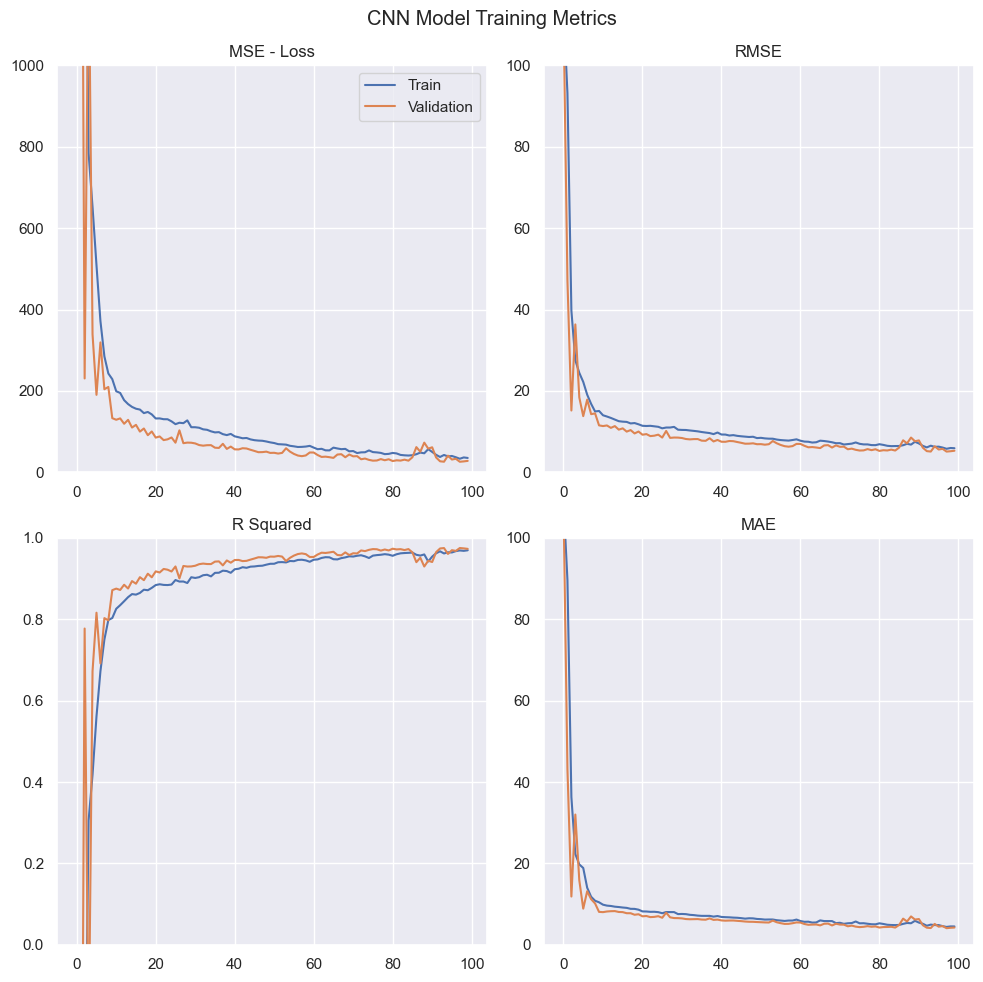

In [ ]:
plot_loss(history, title = 'CNN Model Training Metrics')

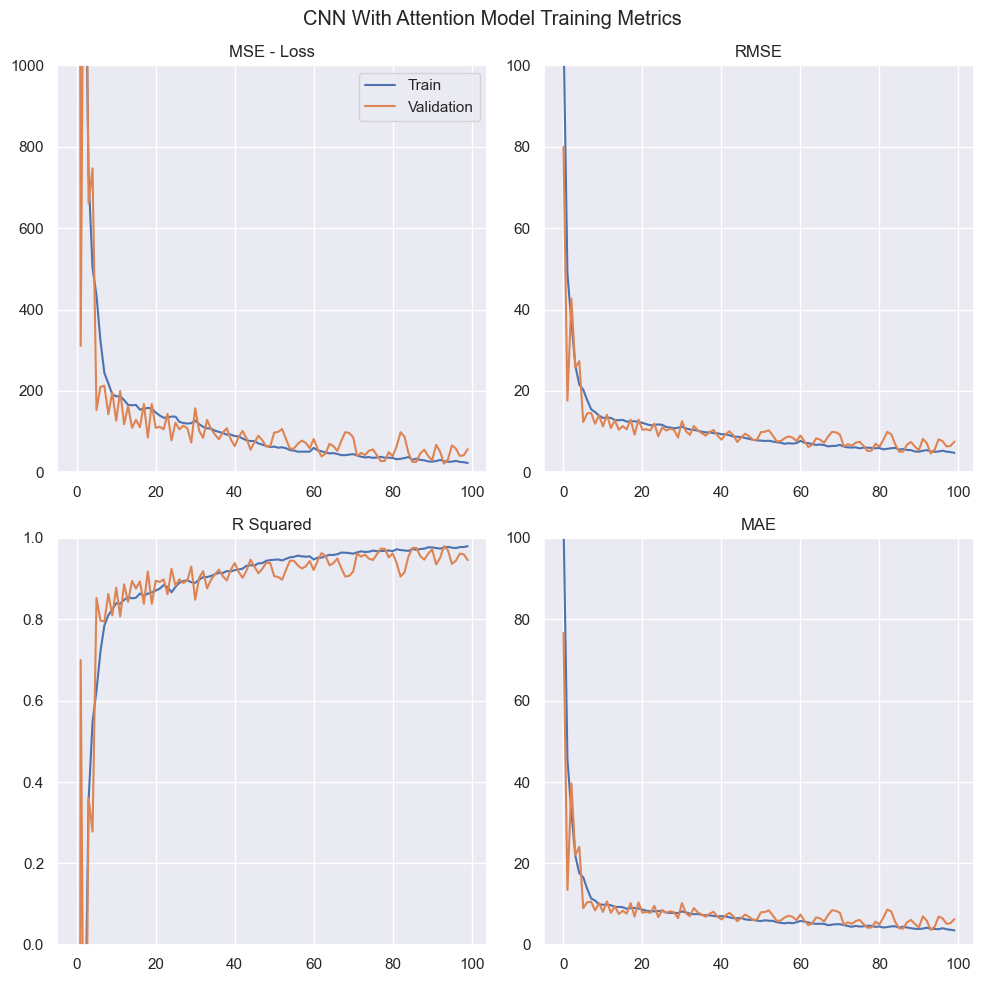

In [ ]:
plot_loss(history_att, title = 'CNN With Attention Model Training Metrics')

30/30 [==============================] - 3s 98ms/step


C:\Users\jmend\anaconda3\envs\tf\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\jmend\anaconda3\envs\tf\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\jmend\anaconda3\envs\tf\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\jmend\anaconda3\envs\tf\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

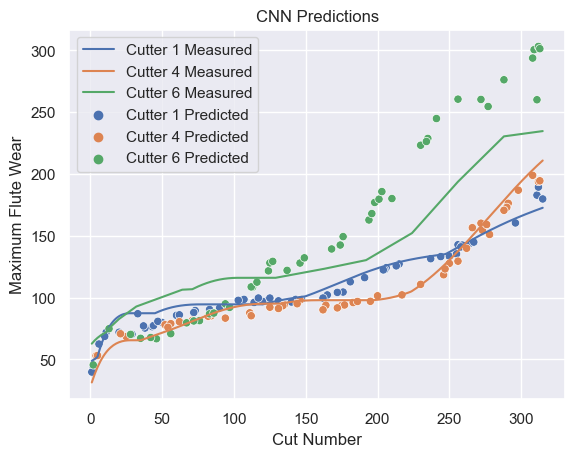

In [ ]:
plot_predictions(CNN, title = 'CNN Predictions')

30/30 [==============================] - 4s 108ms/step


C:\Users\jmend\anaconda3\envs\tf\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\jmend\anaconda3\envs\tf\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\jmend\anaconda3\envs\tf\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\jmend\anaconda3\envs\tf\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

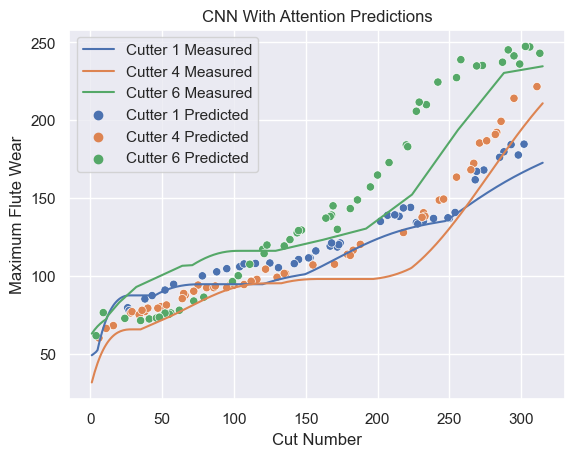

In [ ]:
plot_predictions(CNN_with_attention, title = 'CNN With Attention Predictions')

In [ ]:
history.history

{'loss': [13054.349609375,
  9128.1943359375,
  1758.9615478515625,
  784.5014038085938,
  651.8528442382812,
  508.7270812988281,
  371.4910583496094,
  284.81512451171875,
  242.79916381835938,
  228.86497497558594,
  199.13702392578125,
  194.9837188720703,
  177.24403381347656,
  167.62380981445312,
  160.68948364257812,
  156.2338104248047,
  154.15187072753906,
  145.4338836669922,
  148.2646942138672,
  142.28131103515625,
  132.27662658691406,
  132.45001220703125,
  130.4817352294922,
  130.3505096435547,
  125.19856262207031,
  118.3085708618164,
  121.79544067382812,
  120.7410888671875,
  127.60176849365234,
  110.8256607055664,
  110.72396850585938,
  109.47907257080078,
  105.60488891601562,
  104.45301818847656,
  100.67764282226562,
  98.04200744628906,
  98.67668914794922,
  93.75839233398438,
  91.4259262084961,
  94.33763122558594,
  88.34799194335938,
  86.1506118774414,
  83.65331268310547,
  84.32567596435547,
  80.8679428100586,
  78.9256820678711,
  77.960464477

In [ ]:
history.history

model_dict = {'CNN':history, 'CNN with Attention':history_att}

model_metrics = []

for key,value in model_dict.items():
    for item,value_list in value.history.items():
        if "val" in item:
            data_type = 'validation'
            model_metrics.append([key, data_type, item.replace('val_',''), value_list[-1]])
        else:
            data_type = 'training'
            model_metrics.append([key, data_type, item, value_list[-1]])

df_calc_metrics = df_wear_data[df_wear_data.cutter == 'c6']
model_dict_test = {'CNN':CNN, 'CNN with Attention':CNN_with_attention}

for key,value in model_dict_test.items():
    df_calc_metrics['predicted_wear'] = predict_points_in_frame(df_calc_metrics, X_learned_scale, value)
    loss = sum((df_calc_metrics.max_wear - df_calc_metrics.predicted_wear)**2)/len(df_calc_metrics)
    r_square = 1 - sum((df_calc_metrics.max_wear - df_calc_metrics.predicted_wear)**2)/\
                sum((df_calc_metrics.max_wear - df_calc_metrics.max_wear.mean())**2)
    rmse = np.sqrt(loss)
    mae = sum(abs(df_calc_metrics.max_wear - df_calc_metrics.predicted_wear))/len(df_calc_metrics)

    metric_dict = {
                   'loss':loss,
                   'rmse':rmse,
                   'mean_absolute_error':mae,
                   'r_squared':r_square
                    }
    for metric, metric_value in metric_dict.items():
            model_metrics.append([key, 'hold out', metric, metric_value])


df_metrics = pd.DataFrame().from_records(model_metrics)
df_metrics.columns = ['Model','Dataset','Metric','Value']
df_metrics

10/10 [==============================] - 1s 92ms/step


C:\Users\jmend\AppData\Local\Temp\ipykernel_21532\3737060458.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_calc_metrics['predicted_wear'] = predict_points_in_frame(df_calc_metrics, X_learned_scale, value)


10/10 [==============================] - 1s 100ms/step


C:\Users\jmend\AppData\Local\Temp\ipykernel_21532\3737060458.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_calc_metrics['predicted_wear'] = predict_points_in_frame(df_calc_metrics, X_learned_scale, value)


,Model,Dataset,Metric,Value
0,CNN,training,loss,35.273010
1,CNN,training,rmse,5.920386
2,CNN,training,mean_absolute_error,4.509732
3,CNN,training,r_squared,0.969381
4,CNN,validation,loss,28.049196
5,CNN,validation,rmse,5.296149
6,CNN,validation,mean_absolute_error,4.240485
7,CNN,validation,r_squared,0.972890
8,CNN with Attention,training,loss,22.939951
9,CNN with Attention,training,rmse,4.771824


C:\Users\jmend\anaconda3\envs\tf\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\jmend\anaconda3\envs\tf\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\jmend\anaconda3\envs\tf\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\jmend\anaconda3\envs\tf\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

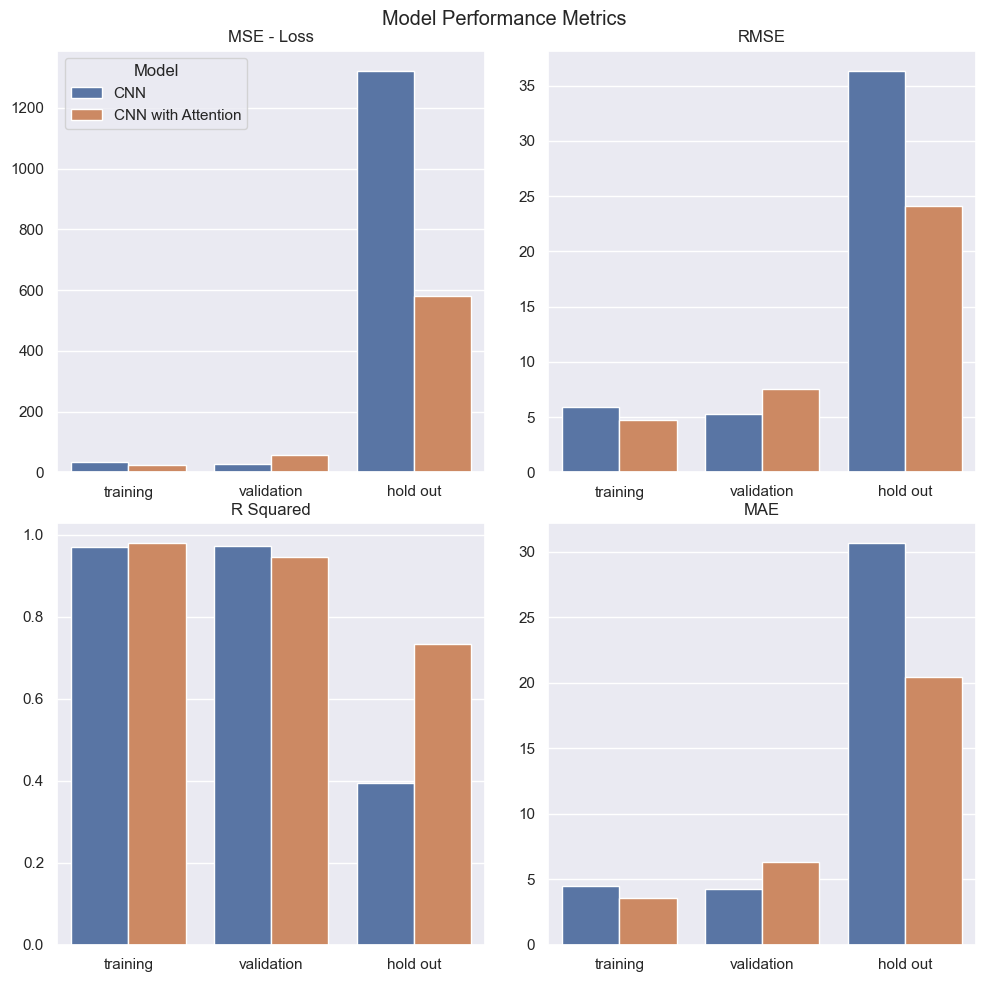

In [ ]:
fig,axes = plt.subplots(2,2, figsize = (10,10))
fig.suptitle('Model Performance Metrics')
fig.tight_layout()

sns.barplot(data=df_metrics[df_metrics.Metric == 'loss'], x='Dataset', y='Value', hue='Model', ax=axes[0,0])
axes[0,0].set_xlabel('')
axes[0,0].set_ylabel('')
axes[0,0].set_title('MSE - Loss')

sns.barplot(data=df_metrics[df_metrics.Metric == 'rmse'], x='Dataset', y='Value', hue='Model', ax=axes[0,1])
axes[0,1].set_xlabel('')
axes[0,1].set_ylabel('')
axes[0,1].set_title('RMSE')
axes[0,1].legend().set_visible(False)

sns.barplot(data=df_metrics[df_metrics.Metric == 'r_squared'], x='Dataset', y='Value', hue='Model', ax=axes[1,0])
axes[1,0].set_xlabel('')
axes[1,0].set_ylabel('')
axes[1,0].set_title('R Squared')
axes[1,0].legend().set_visible(False)

sns.barplot(data=df_metrics[df_metrics.Metric == 'mean_absolute_error'], x='Dataset', y='Value', hue='Model', ax=axes[1,1])
axes[1,1].set_xlabel('')
axes[1,1].set_ylabel('')
axes[1,1].set_title('MAE')
axes[1,1].legend().set_visible(False)


C:\Users\jmend\anaconda3\envs\tf\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\jmend\anaconda3\envs\tf\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\jmend\anaconda3\envs\tf\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\jmend\anaconda3\envs\tf\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

Text(0.5, 1.0, 'Individual Flute Wear on Cutter 1')

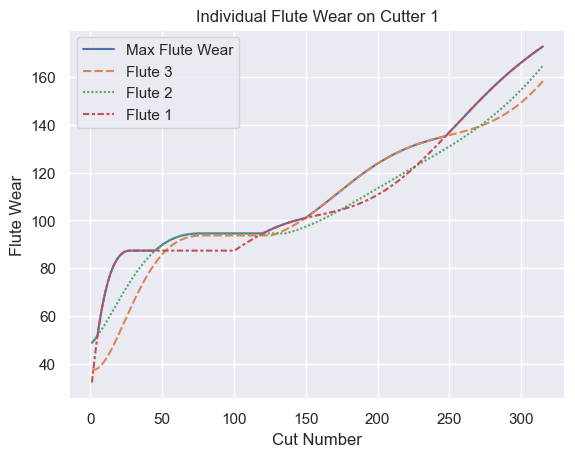

In [ ]:
#Plot FLutes
flutes = ['flute_1', 'flute_2', 'flute_3', 'max_wear']
not_flutes = [col for col in df_wear_data.columns if col not in flutes]
new_names = ['Flute 1', 'Flute 2', 'Flute 3', 'Max Flute Wear']
new_names = dict(zip(flutes, new_names))

fig, ax = plt.subplots()

df_plot = pd.melt(df_wear_data[df_wear_data.cutter == 'c1'], id_vars = not_flutes, value_vars=flutes).sort_values(by='variable', ascending=False)

df_plot['variable'] = df_plot['variable'].apply(lambda x: new_names[x])

sns.lineplot(data=df_plot, x = 'cut', y='value',hue = 'variable',style = 'variable', ax =ax)
ax.set_xlabel('Cut Number')
ax.set_ylabel('Flute Wear')
ax.legend_.set_title(None)
ax.set_title('Individual Flute Wear on Cutter 1')

C:\Users\jmend\anaconda3\envs\tf\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\jmend\anaconda3\envs\tf\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


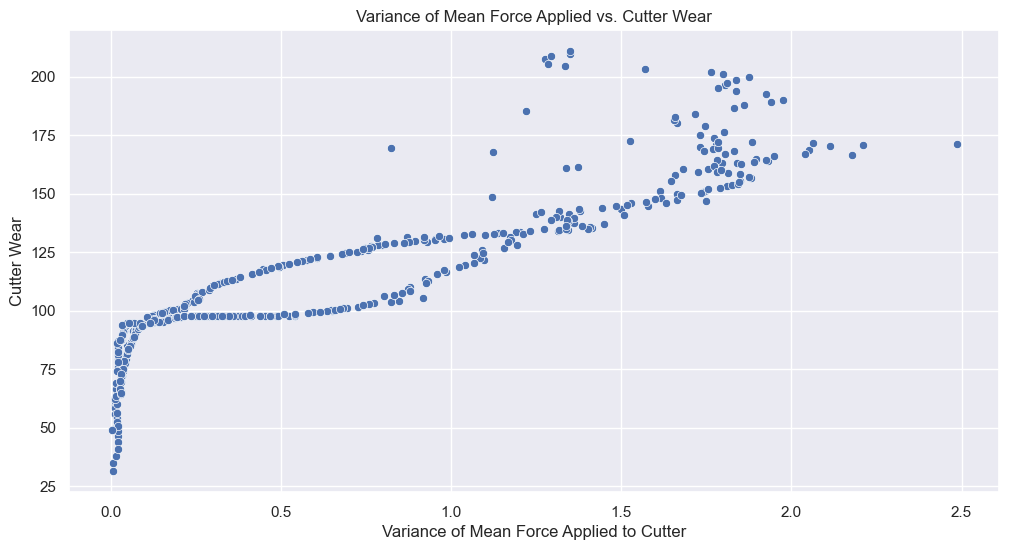

C:\Users\jmend\anaconda3\envs\tf\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\jmend\anaconda3\envs\tf\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


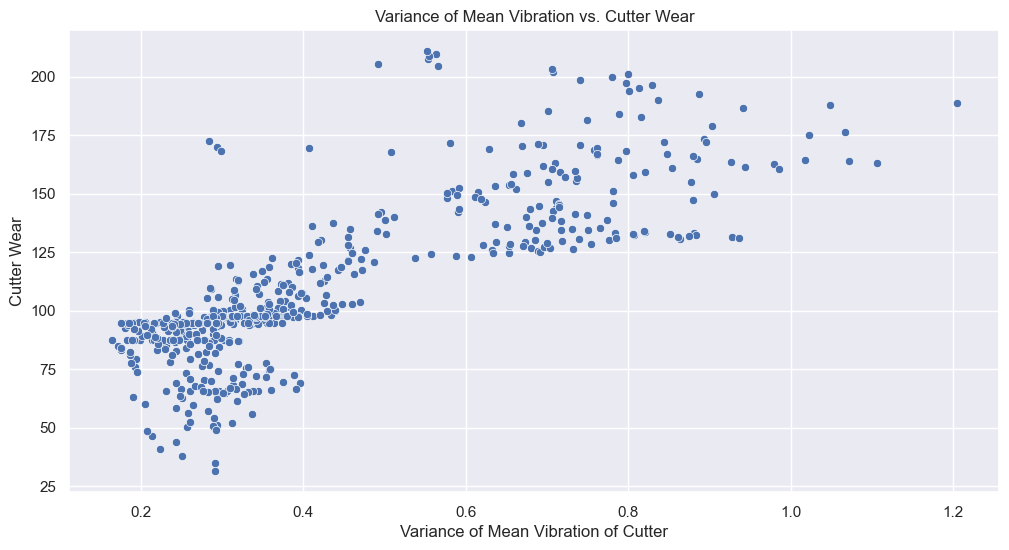

C:\Users\jmend\anaconda3\envs\tf\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\jmend\anaconda3\envs\tf\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


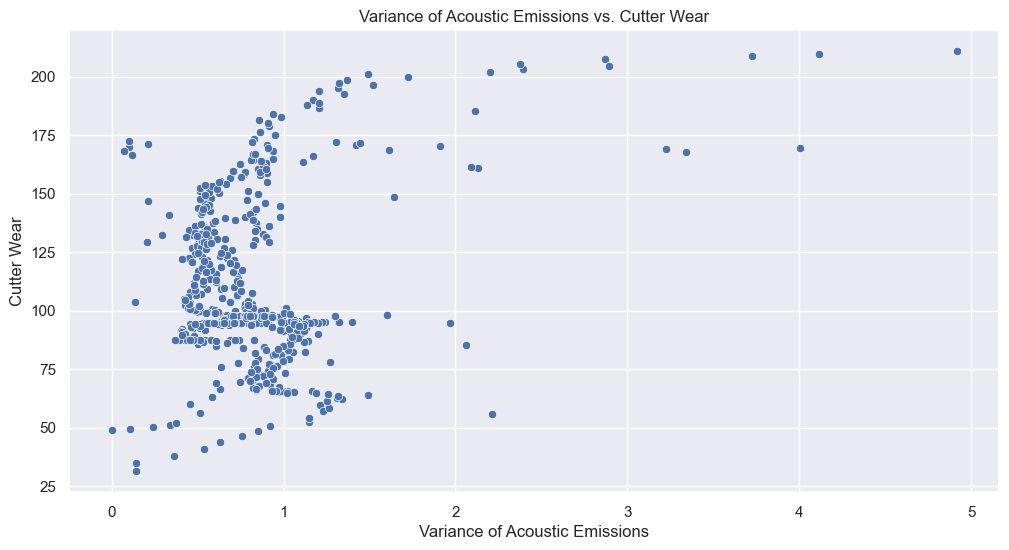

C:\Users\jmend\anaconda3\envs\tf\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\jmend\anaconda3\envs\tf\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\jmend\anaconda3\envs\tf\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\jmend\anaconda3\envs\tf\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

C:\Users\jmend\anaconda3\envs\tf\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


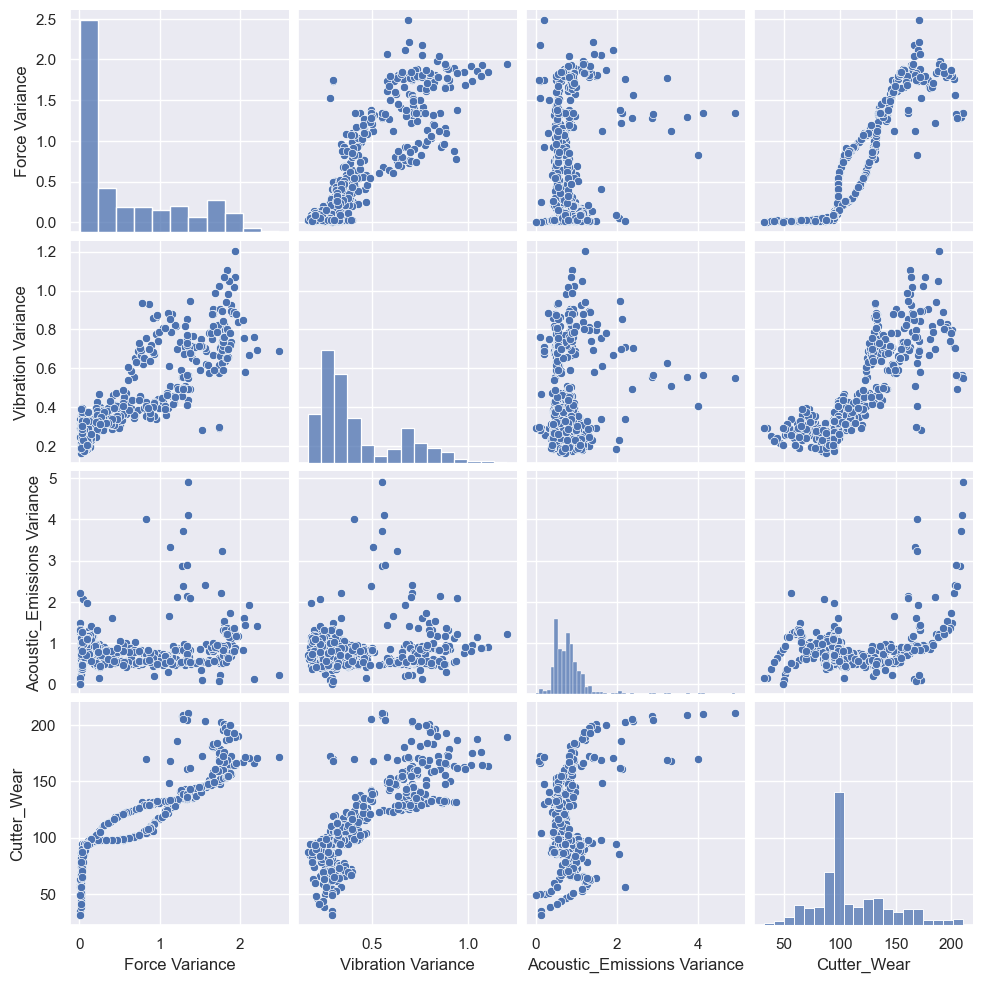

In [ ]:
# Calculate variance of the time series and means across the cutters to yield correct shapes
Train_force_mean = np.mean(X_train_force[:, :, :, 0], axis=2)
Train_vibe_mean = np.mean(X_train_vibe[:, :, :, 0], axis=2)

Train_force_var = np.var(Train_force_mean, axis=1)
Train_vibe_var = np.var(Train_vibe_mean, axis=1)

Train_ae_var = np.var(X_train_ae[:, :, 0], axis=1 )

# Scatter plot for force applied vs. cutter wear
plt.figure(figsize=(12, 6))
sns.scatterplot(x=Train_force_var, y=y_train)
plt.title('Variance of Mean Force Applied vs. Cutter Wear')
plt.xlabel('Variance of Mean Force Applied to Cutter')
plt.ylabel('Cutter Wear')
plt.show()

# Scatter plot for vibration vs. cutter wear
plt.figure(figsize=(12, 6))
sns.scatterplot(x=Train_vibe_var, y=y_train)
plt.title('Variance of Mean Vibration vs. Cutter Wear')
plt.xlabel('Variance of Mean Vibration of Cutter')
plt.ylabel('Cutter Wear')
plt.show()

# Scatter plot for acoustic emissions vs. cutter wear
plt.figure(figsize=(12, 6))
sns.scatterplot(x=Train_ae_var, y=y_train)
plt.title('Variance of Acoustic Emissions vs. Cutter Wear')
plt.xlabel('Variance of Acoustic Emissions')
plt.ylabel('Cutter Wear')
plt.show()

# Pairplot to visualize relationships between all variables
data_for_pairplot = pd.DataFrame({
 'Force Variance': Train_force_var,
 'Vibration Variance': Train_vibe_var,
 'Acoustic_Emissions Variance': Train_ae_var,
 'Cutter_Wear': y_train
})
sns.pairplot(data_for_pairplot)
plt.show()